In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 9.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
import torch

from torchmetrics.classification import MulticlassAccuracy

import time

In [3]:
from utils_v2 import Flowers102Classifier, plot_training_runs, get_train_val_test_loader, FineTuneType, TrainingRun

In [4]:
def transfer_learning_on_backbone(backbones, feature_extract_epochs, fine_tune_epochs):
    """Run transfer learning on multiple backbones for this classification task.
    The choice of the backbone (pre-trained model) is a hyper-parameter.

    We perform transfer-learning in 2 steps:
    1. Feature extraction, which is run for feature_extract_epochs, and
    2. Fine-tuning, which is run for fine_tune_epochs.

    We save the model with the best validation accuracy after every epoch.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Let's train the last classification later of the pre-trained model with the
    # specified backbone on the Flowers 102 dataset.

    training_runs = {}
    for backbone in backbones:
        start_time = time.time()
        best_cp_path = f'{backbone}_Flowers102_best.pt'
        print(f"Running feature extraction on a {backbone} backbone for {feature_extract_epochs} epochs.\n")
        fc = Flowers102Classifier(backbone=backbone)
        fc.to(device)

        optimizer = torch.optim.Adam(fc.parameters())
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.3)
        accuracy = MulticlassAccuracy(num_classes=102, average='micro').to(device)

        # First freeze all the weights except for the newly added Linear layer.
        fc.fine_tune(FineTuneType.NEW_LAYERS)

        best_test_accuracy = 0.0
        training_run = TrainingRun()
        training_runs[backbone] = training_run

        fc.train_multiple_epochs_and_save_best_checkpoint(
            train_loader,
            train_val_loader,
            validation_loader,
            accuracy,
            optimizer,
            scheduler,
            feature_extract_epochs,
            best_cp_path,
            training_run,
        )

        print(f"Done with feature extraction for {backbone}-based model. Ran for {feature_extract_epochs} epochs.")

        best_val_accuracy = fc.get_metrics("val")['accuracy']
        print(f"[{backbone}] Best val accuracy after feature extraction is {best_val_accuracy}\n")
        print(f"Running fine-tuning for {fine_tune_epochs} epochs")

        # Set all the parameters to be trainable.Fine-tuning
        fc.fine_tune(FineTuneType.ALL)

        optimizer = torch.optim.Adam(fc.get_optimizer_params(), lr=1e-8)
        # Every 2 steps reduce the LR to 70% of the previous value.
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)

        fc.train_multiple_epochs_and_save_best_checkpoint(
            train_loader,
            train_val_loader,
            validation_loader,
            accuracy,
            optimizer,
            scheduler,
            fine_tune_epochs,
            best_cp_path,
            training_run,
        )
        print(f"Total time: {time.time() - start_time}")
        print("-------------------------------------------------------------------------")
        print(f"Accuracy of {backbone}-based pre-trained model with last layer replaced.")
        fc.eval()
        fc.evaluate(test_loader, accuracy, 0, "Val")
        print("-------------------------------------------------------------------------")


    # end for (backbone)

    # Now plot the training runs.
    plot_training_runs(training_runs)


# end def

# Without Mixup

100%|██████████| 344862509/344862509 [00:02<00:00, 168659353.29it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1334309.64it/s]


100%|██████████| 14989/14989 [00:00<00:00, 34448450.77it/s]


Running feature extraction on a resnet18 backbone for 16 epochs.



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


[1] Train Loss: 4.70722
[1] Train Loss: 3.91458, Accuracy: 0.16155
[1] Val Loss: 4.03047, Accuracy: 0.13714
Current valdation accuracy 13.71 is better than previous best of 0.00. Saving checkpoint.
[2] Train Loss: 3.64647
[2] Train Loss: 3.02272, Accuracy: 0.52065
[2] Val Loss: 3.27079, Accuracy: 0.39272
Current valdation accuracy 39.27 is better than previous best of 13.71. Saving checkpoint.
[3] Train Loss: 2.92480
[3] Train Loss: 2.38641, Accuracy: 0.68931
[3] Val Loss: 2.71954, Accuracy: 0.54339
Current valdation accuracy 54.34 is better than previous best of 39.27. Saving checkpoint.
[4] Train Loss: 2.35902
[4] Train Loss: 1.86625, Accuracy: 0.78488
[4] Val Loss: 2.32406, Accuracy: 0.61789
Current valdation accuracy 61.79 is better than previous best of 54.34. Saving checkpoint.
[5] Train Loss: 1.96485
[5] Train Loss: 1.52795, Accuracy: 0.82241
[5] Val Loss: 1.99927, Accuracy: 0.69559
Current valdation accuracy 69.56 is better than previous best of 61.79. Saving checkpoint.
[6] Tr

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 169MB/s]


[1] Train Loss: 4.41557
[1] Train Loss: 3.74444, Accuracy: 0.57952
[1] Val Loss: 3.88840, Accuracy: 0.43248
Current valdation accuracy 43.25 is better than previous best of 0.00. Saving checkpoint.
[2] Train Loss: 3.51025
[2] Train Loss: 3.01032, Accuracy: 0.81431
[2] Val Loss: 3.29371, Accuracy: 0.65778
Current valdation accuracy 65.78 is better than previous best of 43.25. Saving checkpoint.
[3] Train Loss: 2.83084
[3] Train Loss: 2.43908, Accuracy: 0.86607
[3] Val Loss: 2.83504, Accuracy: 0.68485
Current valdation accuracy 68.48 is better than previous best of 65.78. Saving checkpoint.
[4] Train Loss: 2.33094
[4] Train Loss: 2.04848, Accuracy: 0.90402
[4] Val Loss: 2.49752, Accuracy: 0.72907
Current valdation accuracy 72.91 is better than previous best of 68.48. Saving checkpoint.
[5] Train Loss: 1.97968
[5] Train Loss: 1.66674, Accuracy: 0.89258
[5] Val Loss: 2.18005, Accuracy: 0.74233
Current valdation accuracy 74.23 is better than previous best of 72.91. Saving checkpoint.
[6] Tr

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:05<00:00, 47.5MB/s]


[1] Train Loss: 4.43701
[1] Train Loss: 3.68247, Accuracy: 0.59598
[1] Val Loss: 3.83718, Accuracy: 0.42773
Current valdation accuracy 42.77 is better than previous best of 0.00. Saving checkpoint.
[2] Train Loss: 3.37585
[2] Train Loss: 2.90263, Accuracy: 0.76088
[2] Val Loss: 3.16313, Accuracy: 0.60798
Current valdation accuracy 60.80 is better than previous best of 42.77. Saving checkpoint.
[3] Train Loss: 2.64696
[3] Train Loss: 2.31948, Accuracy: 0.85686
[3] Val Loss: 2.69432, Accuracy: 0.69741
Current valdation accuracy 69.74 is better than previous best of 60.80. Saving checkpoint.
[4] Train Loss: 2.09004
[4] Train Loss: 1.81003, Accuracy: 0.89411
[4] Val Loss: 2.32891, Accuracy: 0.74093
Current valdation accuracy 74.09 is better than previous best of 69.74. Saving checkpoint.
[5] Train Loss: 1.70754
[5] Train Loss: 1.50657, Accuracy: 0.90639
[5] Val Loss: 2.04882, Accuracy: 0.74916
Current valdation accuracy 74.92 is better than previous best of 74.09. Saving checkpoint.
[6] Tr

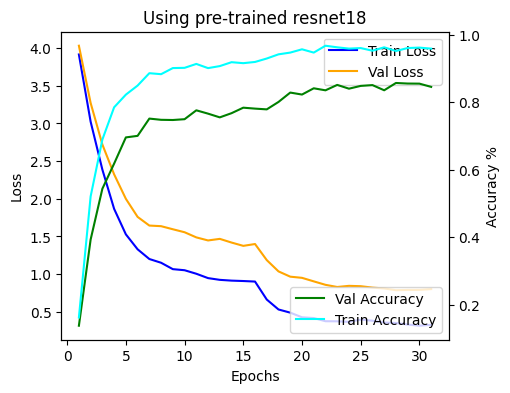

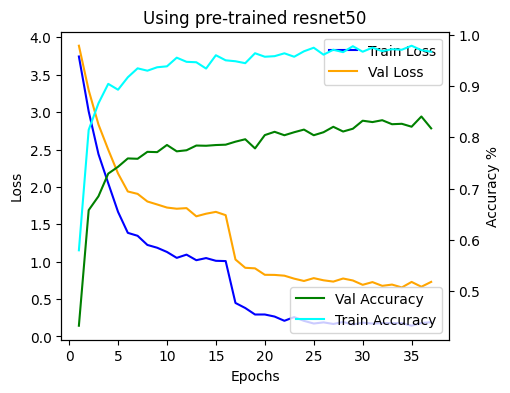

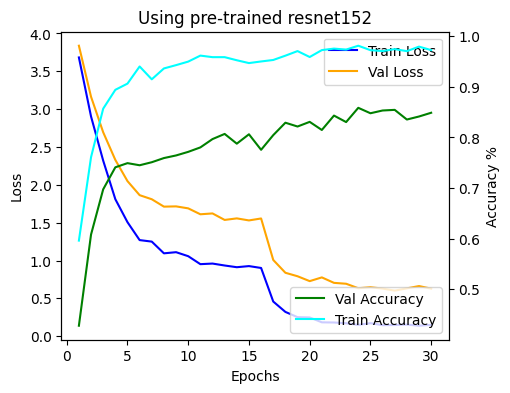

In [5]:
backbones = ["resnet18", "resnet50", "resnet152"]
train_loader, train_val_loader,  validation_loader, test_loader = get_train_val_test_loader()
transfer_learning_on_backbone(backbones, feature_extract_epochs=16, fine_tune_epochs=100)

# With Mixup

Running feature extraction on a resnet18 backbone for 16 epochs.

[1] Train Loss: 4.94551
[1] Train Loss: 4.30174, Accuracy: 0.04688
[1] Val Loss: 4.36440, Accuracy: 0.05287
Current valdation accuracy 5.29 is better than previous best of 0.00. Saving checkpoint.
[2] Train Loss: 4.39931
[2] Train Loss: 3.71538, Accuracy: 0.26228
[2] Val Loss: 3.86560, Accuracy: 0.19727
Current valdation accuracy 19.73 is better than previous best of 5.29. Saving checkpoint.
[3] Train Loss: 4.06903
[3] Train Loss: 3.27109, Accuracy: 0.44699
[3] Val Loss: 3.46717, Accuracy: 0.35477
Current valdation accuracy 35.48 is better than previous best of 19.73. Saving checkpoint.
[4] Train Loss: 3.68975
[4] Train Loss: 2.80573, Accuracy: 0.57059
[4] Val Loss: 3.06318, Accuracy: 0.46680
Current valdation accuracy 46.68 is better than previous best of 35.48. Saving checkpoint.
[5] Train Loss: 3.59820
[5] Train Loss: 2.53187, Accuracy: 0.62793
[5] Val Loss: 2.85101, Accuracy: 0.51437
Current valdation accuracy 51.44 

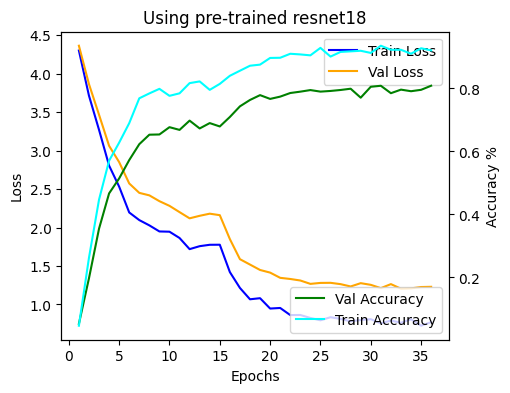

In [6]:
backbones = ["resnet18"]
train_loader, train_val_loader,  validation_loader, test_loader = get_train_val_test_loader(mixup = True)
transfer_learning_on_backbone(backbones, feature_extract_epochs=16, fine_tune_epochs=100)